# Inspect Data

In [285]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split


## Loading dataset and creating dfs

In [286]:
# Load the features and keep both columns (index and name)
features = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)

# Create unique feature names by combining the index and the feature name
unique_column_names = [f"{row[0]}_{row[1]}" for index, row in features.iterrows()]

# Load X_train and X_test with the unique headers
X_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None, names=unique_column_names)
X_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None, names=unique_column_names)

# Load y_train and y_test without modifying column names
y_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', delim_whitespace=True, header=None)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

subject_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt', delim_whitespace=True, header=None)
subject_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt', delim_whitespace=True, header=None)

## Checking Class distributions

In [287]:
# Check for class distribution in y_train
class_distribution_train = y_train[0].value_counts()
print("Class distribution in y_train:")
print(class_distribution_train)

# Check for class distribution in y_test
class_distribution_test = y_test[0].value_counts()
print("\nClass distribution in y_test:")
print(class_distribution_test)

Class distribution in y_train:
0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64

Class distribution in y_test:
0
6    279
4    256
5    254
2    246
1    242
3    197
Name: count, dtype: int64


In [288]:
label_mapping = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

y_train_labels = y_train.copy()
# Create a new column in y_train for descriptive labels
y_train_labels['Descriptive Label'] = y_train_labels[0].replace(label_mapping)

y_test_labels = y_train.copy()
# Create a new column in y_train for descriptive labels
y_test_labels['Descriptive Label'] = y_test_labels[0].replace(label_mapping)

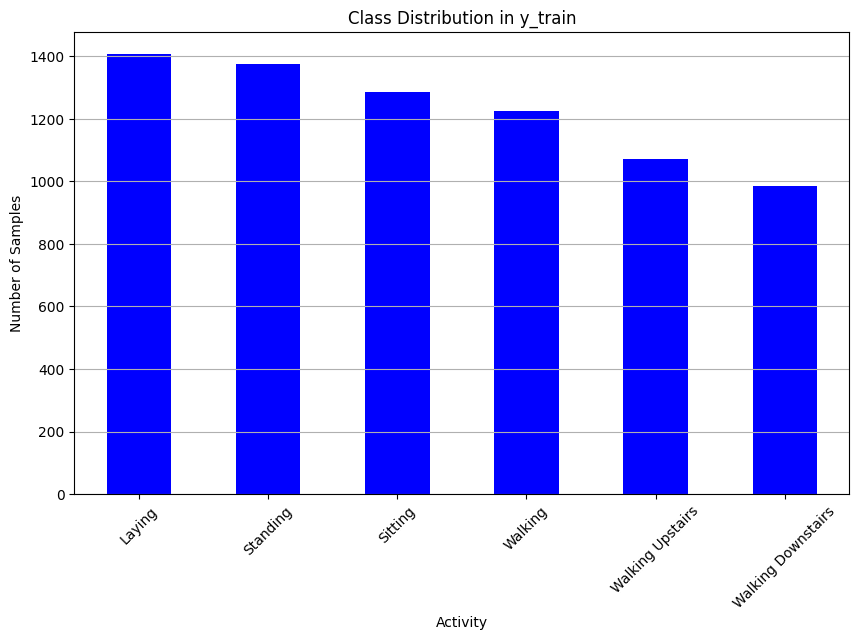

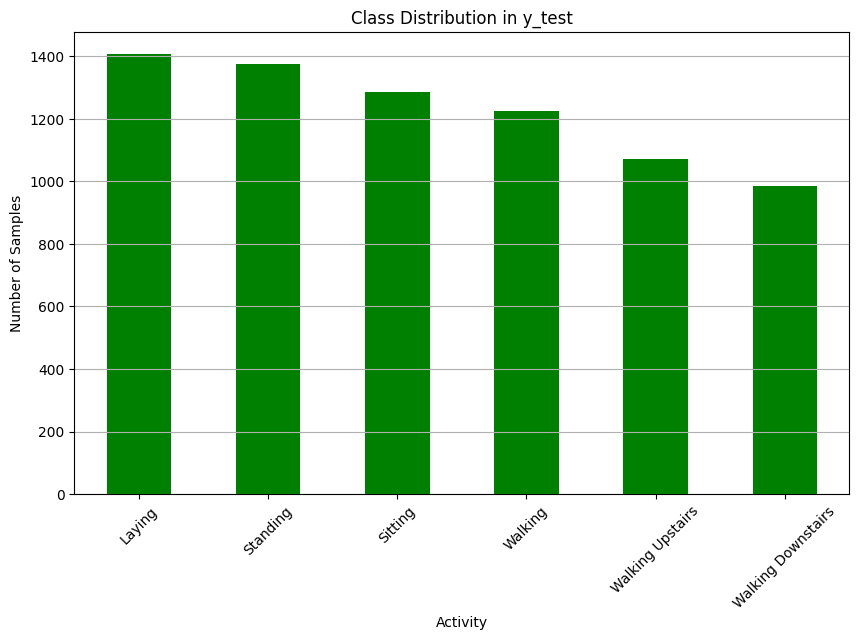

In [289]:
# Bar chart for y_train class distribution
class_distribution_train = y_train_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_train.plot(kind='bar', color='blue')
plt.title('Class Distribution in y_train')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Bar chart for y_train class distribution
class_distribution_train = y_test_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_train.plot(kind='bar', color='green')
plt.title('Class Distribution in y_test')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Check and deal with missing values

In [290]:
# Check for missing values in X_train
missing_values_X_train = X_train.isnull().sum()
print("Missing values in X_train:\n", missing_values_X_train[missing_values_X_train > 0])

# Check for missing values in X_test
missing_values_X_test = X_test.isnull().sum()
print("\nMissing values in X_test:\n", missing_values_X_test[missing_values_X_test > 0])

# Check for missing values in y_train
missing_values_y_train = y_train.isnull().sum()
print("\nMissing values in y_train:\n", missing_values_y_train[missing_values_y_train > 0])

# Check for missing values in y_test
missing_values_y_test = y_test.isnull().sum()
print("\nMissing values in y_test:\n", missing_values_y_test[missing_values_y_test > 0])

Missing values in X_train:
 Series([], dtype: int64)

Missing values in X_test:
 Series([], dtype: int64)

Missing values in y_train:
 Series([], dtype: int64)

Missing values in y_test:
 Series([], dtype: int64)


In [291]:
# Assuming X_train is your training dataset as a DataFrame
correlation_matrix = X_train.corr()

# Set a threshold for correlation
threshold = 0.75

# Get the absolute correlation matrix
abs_correlation = correlation_matrix.abs()

# Create a DataFrame to hold the pairs of correlated features
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(abs_correlation.columns)):
    for j in range(i):
        # Check if the correlation is above the threshold and features are different
        if abs_correlation.iloc[i, j] > threshold and abs_correlation.columns[i] != abs_correlation.columns[j]:
            highly_correlated_pairs.append((abs_correlation.columns[i], abs_correlation.columns[j], abs_correlation.iloc[i, j]))

# Create a DataFrame for better visualization
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Print only the pairs of highly correlated features where Feature 1 is different from Feature 2
print("Highly correlated features:")
print(highly_correlated_df)

Highly correlated features:
                      Feature 1                  Feature 2  Correlation
0            5_tBodyAcc-std()-Y         4_tBodyAcc-std()-X     0.927461
1            6_tBodyAcc-std()-Z         4_tBodyAcc-std()-X     0.851668
2            6_tBodyAcc-std()-Z         5_tBodyAcc-std()-Y     0.895510
3            7_tBodyAcc-mad()-X         4_tBodyAcc-std()-X     0.998632
4            7_tBodyAcc-mad()-X         5_tBodyAcc-std()-Y     0.922803
...                         ...                        ...          ...
29480  560_angle(Y,gravityMean)  58_tGravityAcc-energy()-Y     0.880564
29481  560_angle(Y,gravityMean)   559_angle(X,gravityMean)     0.783848
29482  561_angle(Z,gravityMean)    43_tGravityAcc-mean()-Z     0.995070
29483  561_angle(Z,gravityMean)     52_tGravityAcc-max()-Z     0.992869
29484  561_angle(Z,gravityMean)     55_tGravityAcc-min()-Z     0.990991

[29485 rows x 3 columns]


## Identify number of components needed for PCA to maintain 95% of Variance

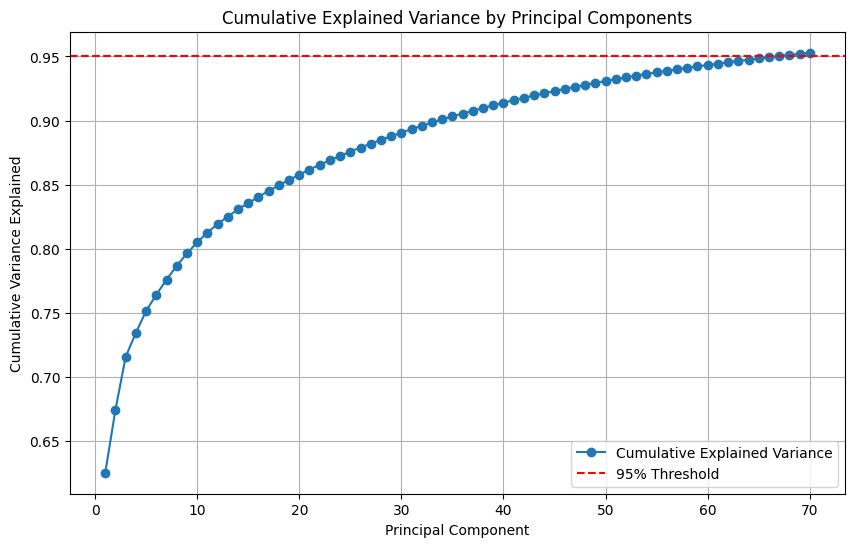

Total variance explained by the first 1 components: 0.6255
Total variance explained by the first 2 components: 0.6747
Total variance explained by the first 3 components: 0.7159
Total variance explained by the first 4 components: 0.7346
Total variance explained by the first 5 components: 0.7516
Total variance explained by the first 6 components: 0.7643
Total variance explained by the first 7 components: 0.7761
Total variance explained by the first 8 components: 0.7868
Total variance explained by the first 9 components: 0.7965
Total variance explained by the first 10 components: 0.8050
Total variance explained by the first 11 components: 0.8127
Total variance explained by the first 12 components: 0.8194
Total variance explained by the first 13 components: 0.8252
Total variance explained by the first 14 components: 0.8308
Total variance explained by the first 15 components: 0.8357
Total variance explained by the first 16 components: 0.8405
Total variance explained by the first 17 componen

In [292]:
# Fit PCA on your dataset
pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train)  # Use fit_transform to get the transformed data
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')  # Optional: add a line for the 90% threshold
plt.legend()
plt.show()

# Print total variance explained by each principal component
for i, var in enumerate(cumulative_variance):
    print(f'Total variance explained by the first {i + 1} components: {var:.4f}')

## Transform X_train and X_test using PCA

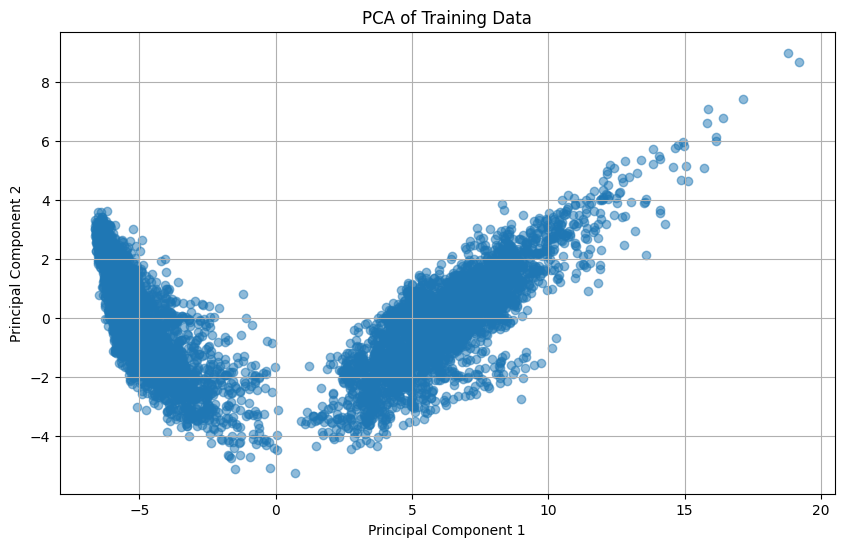

In [293]:
# Assuming X_train_pca is your PCA-transformed training data
pca = PCA(n_components=67)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)


# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [294]:
'''# Define the threshold for anomaly detection
threshold = 3

# Initialize a variable to keep track of the maximum number of anomalies
max_anomalies = 0
max_anomalies_column = None

# Iterate through each column in the training dataset
for col in X_train.columns:
    # Calculate Z-scores for the column
    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()

    # Identify anomalies in the column
    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)

    # Get indices of anomalies for the current column
    anomaly_indices_train = np.where(anomalies_train)[0]

    # Count the number of anomalies detected for the current column
    num_anomalies = len(anomaly_indices_train)
    
    # Print number of anomalies detected for the current column
    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')

    # Check if the current number of anomalies is greater than the max found so far
    if num_anomalies > max_anomalies:
        max_anomalies = num_anomalies
        max_anomalies_column = col

# After iterating through all columns, print the maximum number of anomalies found
print(f'Maximum number of anomalies detected in a single column: {max_anomalies} (Column {max_anomalies_column})')'''

"# Define the threshold for anomaly detection\nthreshold = 3\n\n# Initialize a variable to keep track of the maximum number of anomalies\nmax_anomalies = 0\nmax_anomalies_column = None\n\n# Iterate through each column in the training dataset\nfor col in X_train.columns:\n    # Calculate Z-scores for the column\n    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()\n\n    # Identify anomalies in the column\n    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)\n\n    # Get indices of anomalies for the current column\n    anomaly_indices_train = np.where(anomalies_train)[0]\n\n    # Count the number of anomalies detected for the current column\n    num_anomalies = len(anomaly_indices_train)\n    \n    # Print number of anomalies detected for the current column\n    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')\n\n    # Check if the current number of anomalies is greater than the max found so far\n    if 

## Create, train and evaluate Random Forrest Model

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.98      0.93       242
           2       0.94      0.91      0.93       246
           3       0.93      0.85      0.89       197
           4       0.92      0.81      0.86       256
           5       0.84      0.94      0.89       254
           6       0.99      0.99      0.99       279

    accuracy                           0.92      1474
   macro avg       0.92      0.91      0.91      1474
weighted avg       0.92      0.92      0.92      1474



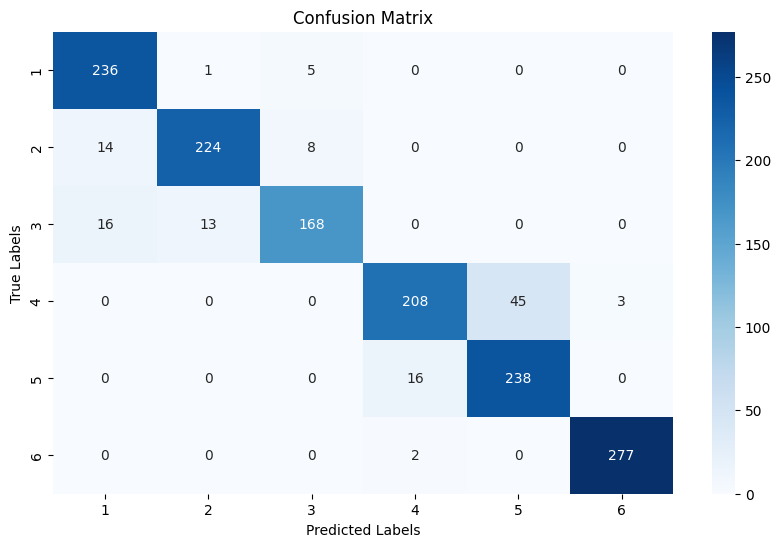

Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


In [295]:
# Fit the Random Forest model, ensuring y_train is a 1D array
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_model.fit(X_train_pca, y_train.values.ravel())  # Flatten y_train to 1D
y_pred = rf_model.predict(X_test_pca)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test.values.ravel(), y_pred))  # Flatten y_test to 1D

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test.values.ravel(), y_pred)  # Flatten y_test to 1D
# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_test.values.ravel(), y_pred)  # Flatten y_test to 1D
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test.values.ravel(), y_pred, average='weighted')  # Flatten y_test to 1D
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test.values.ravel(), y_pred, average='weighted')  # Flatten y_test to 1D
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(y_test.values.ravel(), y_pred, average='weighted')  # Flatten y_test to 1D
print(f"F1 Score: {f1:.2f}")

## Evaluate model for over fitting

In [ ]:
train_accuracy = accuracy_score(y_train.values.ravel(), rf_model.predict(X_train_pca))
test_accuracy = accuracy_score(y_test.values.ravel(), rf_model.predict(X_test_pca))

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

cv_scores = cross_val_score(rf_model, X_train_pca, y_train.values.ravel(), cv=10)
print(f'Mean Cross-Validation Score: {cv_scores.mean():.2f}')

Training Accuracy: 1.00
Test Accuracy: 0.92
Cross-Validation Scores: [0.87831407 0.87423521 0.87891156 0.87346939 0.92108844]
Mean Cross-Validation Score: 0.89
